# SQL Path to Conversion

## 1.Import Librearies

In [2]:
pip install pandas-profiling

Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
from pandas_profiling import ProfileReport
import openpyxl
import pytz
from datetime import datetime

In [3]:
#Format
pd.set_option('display.float_format', '{:0.0f}'.format)

## 2. Inspect Files

In [5]:
# Identify sheets of workbook
wb = openpyxl.load_workbook('SQLTestv3.xlsx') 
res = wb.sheetnames
res

['Test Details', 'Impression', 'Click', 'Conversion']

In [5]:
#Impressions = pd.read_excel("SQLTestv3.xlsx", sheet_name='Impression')
Clicks = pd.read_excel("SQLTestv3.xlsx", sheet_name='Click')
#Conversion = pd.read_excel("SQLTestv3.xlsx", sheet_name='Conversion')

In [ ]:
# Profiling data
prof_imprs = ProfileReport(Impressions)
prof_imprs.to_file(output_file='prof_imprs.html')
prof_imprs

In [ ]:
# Profiling data
prof_click = ProfileReport(Click)
prof_click.to_file(output_file='prof_click.html')
prof_click

In [ ]:
# Profiling data
prof_conversion = ProfileReport(Conversion)
prof_conversion.to_file(output_file='prof_conversion.html')
prof_conversion

## 3 Cleaning

In [6]:
# Drop NaN columns
Impressions = Impressions.dropna()
Clicks = Clicks.dropna()
Conversion = Conversion.dropna()

In [7]:
# Manage time columns
dates_impr = Impressions['event_time'].tolist()
dates_cl = Clicks['event_time'].tolist()
dates_con1 = Conversion['event_time'].tolist()
dates_con2 = Conversion['interaction_time_utc_seconds'].tolist()
#dates

In [8]:
# From UTC To EST
est_dates_impr = []
est = pytz.timezone('US/Eastern')
fmt = '%Y-%m-%d %H:%M:%S'

for i in dates_impr:
    unix_timestamp = i / 1000000.0
    local_time = datetime.fromtimestamp(unix_timestamp)
    time = local_time.astimezone(est).strftime(fmt)
    est_dates_impr.append(time)

In [9]:
# From UTC To EST
est_dates_cl = []
est = pytz.timezone('US/Eastern')
fmt = '%Y-%m-%d %H:%M:%S'

for i in dates_cl:
    unix_timestamp = i / 1000000.0
    local_time = datetime.fromtimestamp(unix_timestamp)
    time = local_time.astimezone(est).strftime(fmt)
    est_dates_cl.append(time)

In [10]:
# From UTC To EST
est_dates_con1 = []
est = pytz.timezone('US/Eastern')
fmt = '%Y-%m-%d %H:%M:%S'

for i in dates_con1:
    unix_timestamp = i / 1000000.0
    local_time = datetime.fromtimestamp(unix_timestamp)
    time = local_time.astimezone(est).strftime(fmt)
    est_dates_con1.append(time)

In [11]:
# From UTC To EST
est_dates_con2 = []
est = pytz.timezone('US/Eastern')
fmt = '%Y-%m-%d %H:%M:%S'

for i in dates_con2:
    unix_timestamp = i / 1000000.0
    local_time = datetime.fromtimestamp(unix_timestamp)
    time = local_time.astimezone(est).strftime(fmt)
    est_dates_con2.append(time)

In [12]:
# From list to df
est_dates_column_imp = pd.DataFrame({'event_time':est_dates_impr})
est_dates_column_cl = pd.DataFrame({'event_time':est_dates_cl})
est_dates_column_con1 = pd.DataFrame({'event_time':est_dates_con1})
est_dates_column_con2 = pd.DataFrame({'interaction_time_utc_seconds':est_dates_con2})

In [14]:
# Drop UTC columns
impres_df = Impressions.drop('event_time', axis=1)
cl_df = Clicks.drop('event_time', axis=1)
con_df = Conversion.drop(Conversion.loc[:, 'event_time':'interaction_time_utc_seconds'].columns, axis=1)

In [16]:
# Add EST dfs
impressions_final = impres_df.join(est_dates_column_imp)
clicks_final = cl_df.join(est_dates_column_cl)
conver_pre = est_dates_column_con1.join(est_dates_column_con2)
conver_final = con_df.join(conver_pre)

In [23]:
# Change date type
impressions_final["event_time"] = pd.to_datetime(impressions_final["event_time"])
clicks_final["event_time"] = pd.to_datetime(clicks_final["event_time"])
conver_final["event_time"] = pd.to_datetime(conver_final["event_time"])
conver_final["interaction_time_utc_seconds"] = pd.to_datetime(conver_final["interaction_time_utc_seconds"])

## 4. Connec to to MySQL

In [58]:
pip install sqlalchemy

Note: you may need to restart the kernel to use updated packages.


In [28]:
from sqlalchemy import create_engine
 
# Define database credentials
user = 'root'
password = '###'
host = '127.0.0.1'
port = 3306
database = 'test_v3'
 
# Connect to MYSQL database 
def get_connection():
    return create_engine(
        url="mysql+pymysql://{0}:{1}@{2}:{3}/{4}".format(
            user, password, host, port, database
        )
    )
 
 
if __name__ == '__main__':
 
    try:
       
        # connection object
        engine = get_connection()
        print(
            f"Connection to the {host} for user {user} created successfully.")
    except Exception as ex:
        print("Connection could not be made due to the following error: \n", ex)

Connection to the 127.0.0.1 for user root created successfully.


In [29]:
# Add tables to database
impressions_final.to_sql(con=engine,name='Impression', if_exists="replace", index=False)
clicks_final.to_sql(con=engine,name='Click', if_exists="replace", index=False)
conver_final.to_sql(con=engine,name='Conversion', if_exists="replace", index=False)

C:\Users\jaqueline.razo\Anaconda3\lib\site-packages\pandas\io\sql.py:1685: UserWarning: The provided table name 'Impression' is not found exactly as such in the database after writing the table, possibly due to case sensitivity issues. Consider using lower case table names.
  warnings.warn(msg, UserWarning)


## 5. Queries

1. Using eastern time (event_time is UTC) across the entire time period (SEP08-15), find the hour that had the most impressions. Return that hour and the total impressions and reach for that particular hour. DO NOT use DATE_TRUNC().


SELECT DATE_FORMAT(event_time, '%Y-%m-%d %H:00:00') <br>
AS hour, COUNT(DISTINCT impression_id) AS total_impressions, <br>
COUNT(DISTINCT user_id) AS reach <br>
FROM impression <br>
WHERE event_time BETWEEN '2018-09-08 00:00:00' AND '2018-09-15 23:59:59' <br>
GROUP BY hour ORDER BY total_impressions DESC <br>
LIMIT 1;

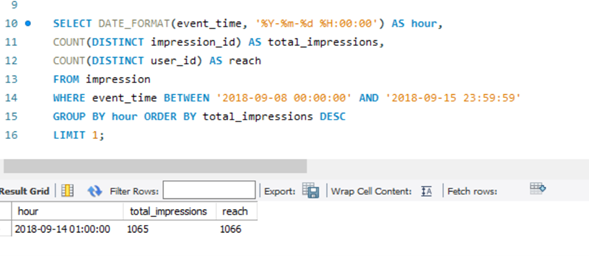

2. Using eastern time for SEP10-13, between 10:00 AM and 2:30 PM on each day, find the campaign id that had the lowest average hourly reach. Return that campaign id and average of it's hourly reach.


SELECT campaign_id, <br>
AVG(reach) AS avg_hourly_reach <br>
FROM ( SELECT campaign_id, <br>
DATE_FORMAT(event_time, '%Y-%m-%d %H:00:00') <br>
AS hour, COUNT(DISTINCT user_id) AS reach <br>
FROM impression <br>
WHERE event_time BETWEEN '2018-09-10 10:00:00' AND '2018-09-13 14:30:00' <br>
GROUP BY campaign_id, hour ) AS hourly_reach <br>
GROUP BY campaign_id <br>
ORDER BY avg_hourly_reach ASC<br> 
LIMIT 1;


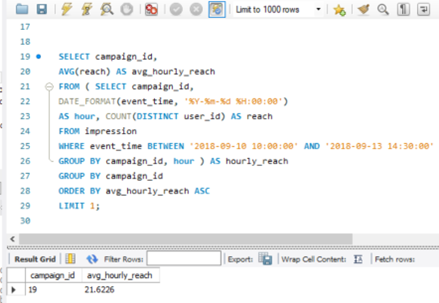

3. Using eastern time for SEP14-16, produce a table with total revenue broken out by site id and day. Conversion actions have associated values as follows: 1:$0.5, 2: $1.0, 3: $5.0, 4: $10.0, and 5: $0.0. Additionally, in the output table create a subtotal row for each site with the corresponding total site revenue and one final row with the total overall revenue across all sites. Ensure that the site subtotal rows are the bottom row for each site in the table, and that the overall total row is at the bottom of the table.


SELECT site_id, <br>
DATE(event_time) AS day, <br>
SUM(CASE WHEN action_id = 1 <br>
THEN 0.5 WHEN action_id = 2 <br>
THEN 1.0 WHEN action_id = 3 <br>
THEN 5.0 WHEN action_id = 4 <br>
THEN 10.0 WHEN action_id = 5 <br>
THEN 0.0 END) AS total_revenue <br>
FROM conversion <br>
WHERE event_time BETWEEN '2018-09-14' AND '2018-09-16' <br>
GROUP BY site_id, day <br>
WITH ROLLUP;


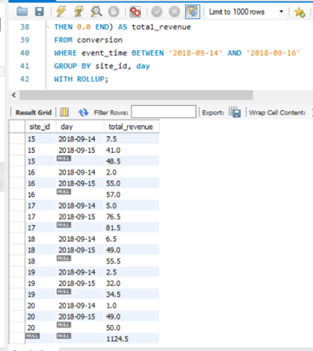

4. Using eatern time across the entire time period (SEP08-15), for users who received an impression return an aggregated table with the total impressions, total reach, count of people who clicked, and count of people who did any of the conversion actions 1 through 4. 


SELECT <br>
COUNT(imp.impression_id) AS total_impressions, <br>
COUNT(DISTINCT imp.user_id) AS total_reach, <br>
COUNT(DISTINCT clk.user_id) AS total_clicks, <br>
COUNT(DISTINCT CASE <br>
WHEN conv.action_id IN (1, 2, 3, 4) <br>
THEN conv.user_id END) AS total_conversions <br>
FROM impression imp <br>
LEFT JOIN click clk ON imp.user_id = clk.user_id <br>
LEFT JOIN conversion conv ON imp.user_id = conv.user_id ;


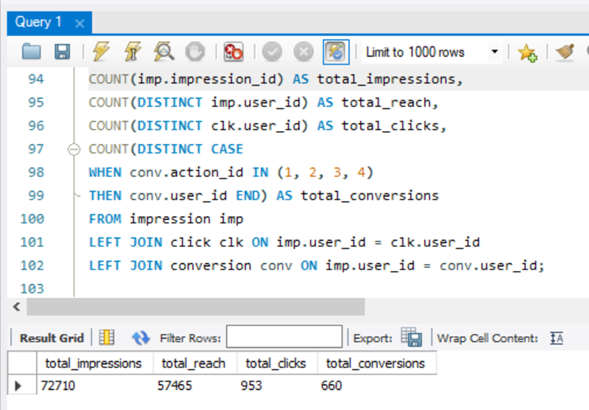

5. Using eatern time across the entire time period (SEP08-15), for users who both converted and clicked, create a table with site_id and total revenue for that site (in descending revenue), but only for conversions that occured within 2 days of a user receiving an impression.


SELECT conv.site_id, <br>
SUM(CASE WHEN conv.action_id = 1 THEN 0.5 <br>
WHEN conv.action_id = 2 THEN 1.0 <br>
WHEN conv.action_id = 3 THEN 5.0 <br>
WHEN conv.action_id = 4 THEN 10.0 ELSE 0.0 END) <br>
AS total_revenue <br>
FROM conversion conv <br>
JOIN click clk ON conv.user_id = clk.user_id <br>
WHERE conv.event_time BETWEEN conv.event_time AND conv.interaction_time_utc_seconds + INTERVAL 2 DAY <br>
GROUP BY conv.site_id <br>
ORDER BY total_revenue DESC; <br>


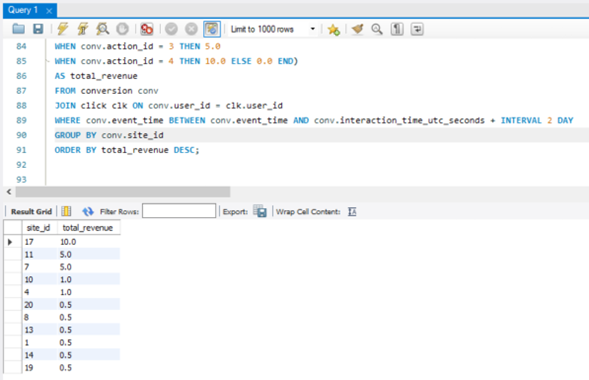